# Проект HR-аналитика

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. Для более точного анализа HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

**Цель:**
- построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика;
- построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**Описание данных:**
В качестве входных данных заказчиком отдельно предоставлены  тренировочная и тестовая выборки, в которых содержится следующая информация:
- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак;
- quit — увольнение сотрудника из компании.

**План работы:**
- предобработка данных;
- исследовательский анализ данных с целью определения необходимой подготовки данных для машинного обучения;
- создание пайплайнов для подготовки данных;
- создание итогового пайплайна;
- поиск лучшей модели из нескольких;
- промежуточный вывод;
- определение портрета уволившегося сотрудника;
- выявление зависимости увольнения от оценки работы;
- предсказание оценки работы для тренировочных данных, которые даны для предсказания уволится ли сотрудник;
- создание пайплайна для поиска лучшей модели;
- общий вывод.

**Загрузка и импорт используемых библиотек и их методов**

In [1]:
!pip install scikit-learn==1.1.3 -q

In [2]:
! pip install matplotlib==3.5.0 -q

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, LinearSVR

from sklearn.metrics import make_scorer

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score

In [4]:
RANDOM_STATE = 42

## Задача 1

### Загрузка данных

In [5]:
# загружаем тренировочные данные
# train_job_satisf = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
train_job_satisf = pd.read_csv('train_job_satisfaction_rate.csv')
train_job_satisf.head(10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
5,405448,hr,middle,low,7,no,no,4,30000,0.78
6,857135,sales,sinior,medium,9,no,no,3,56400,0.56
7,400657,purchasing,middle,high,9,no,no,3,52800,0.44
8,198846,hr,junior,low,1,no,no,2,13200,0.14
9,149797,technology,middle,high,6,no,no,3,54000,0.47


In [6]:
test_features = pd.read_csv('test_features.csv')
test_features.head(10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400


In [7]:
test_target = pd.read_csv('test_target_job_satisfaction_rate.csv')
test_target.head(10)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08
5,817219,0.76
6,269033,0.64
7,962356,0.38
8,649052,0.14
9,532834,0.59


Видим, что данные соответствуют своему описанию из постановки задачи.

### Предобработка данных

#### ```train_job_satisf```

In [8]:
# общая информация
train_job_satisf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


Всего 10 столбцов. Все наименования и типы столбцов корректны. Однако, видим пропуски в столбцах ```dept, level```. Далее учтем это в итоговом пайплайне, так как перед заполнением пропусков с помощью SimpleImputer нужно будет еще определить будет ли использоваться кодировка и какая.

Теперь проверим наличие неявных дубликатов и адекватность значений.

In [9]:
train_job_satisf['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

Неявных дубликатов нет. Пропуски будут учтены в итоговом пайплайне.

In [10]:
train_job_satisf['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

Неявные дубликаты отсутствуют.

In [11]:
train_job_satisf['workload'].unique()

array(['medium', 'high', 'low'], dtype=object)

Неявные дубликаты отсутствуют.

In [12]:
train_job_satisf['employment_years'].unique()

array([ 2,  1,  4,  7,  9,  6,  3, 10,  8,  5], dtype=int64)

Значения соответствуют столбцу.

In [13]:
train_job_satisf['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

Неявные дубликаты отсутствуют.

In [14]:
train_job_satisf['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

Неявные дубликаты отсутствуют.

In [15]:
train_job_satisf['supervisor_evaluation'].unique()

array([1, 5, 2, 3, 4], dtype=int64)

Значения соответствуют столбцу.

In [16]:
train_job_satisf['salary'].unique()

array([24000, 38400, 12000, 18000, 22800, 30000, 56400, 52800, 13200,
       54000, 19200, 40800, 34800, 27600, 26400, 33600, 50400, 15600,
       14400, 25200, 72000, 31200, 32400, 48000, 43200, 46800, 58800,
       84000, 44400, 39600, 37200, 21600, 28800, 62400, 60000, 42000,
       49200, 55200, 57600, 68400, 45600, 51600, 64800, 80400, 20400,
       61200, 76800, 69600, 16800, 36000, 63600, 81600, 66000, 74400,
       67200, 70800, 73200, 75600, 79200, 94800, 78000, 88800, 92400,
       85200, 91200, 98400, 96000, 97200], dtype=int64)

Значения соответствуют столбцу.

In [17]:
train_job_satisf['job_satisfaction_rate'].unique()

array([0.58, 0.76, 0.11, 0.37, 0.2 , 0.78, 0.56, 0.44, 0.14, 0.47, 0.74,
       0.42, 0.32, 0.57, 0.16, 0.69, 0.33, 0.64, 0.39, 0.8 , 0.79, 0.17,
       0.65, 0.18, 0.19, 0.49, 0.63, 0.22, 0.23, 0.5 , 0.35, 0.3 , 0.77,
       0.88, 0.59, 0.21, 0.36, 0.85, 0.7 , 0.48, 0.6 , 0.1 , 0.27, 0.71,
       0.86, 0.54, 0.73, 0.46, 0.31, 0.72, 0.51, 0.61, 0.81, 0.99, 0.15,
       0.91, 0.68, 0.4 , 0.89, 0.67, 0.75, 0.98, 0.26, 0.45, 0.92, 0.82,
       0.66, 0.55, 0.38, 0.53, 0.84, 0.52, 0.24, 0.62, 0.41, 0.28, 0.09,
       0.97, 0.83, 0.25, 0.43, 0.04, 0.13, 0.29, 0.95, 0.93, 0.87, 0.08,
       0.94, 0.07, 0.34, 0.9 , 0.12, 0.06, 0.96, 0.05, 1.  , 0.03])

Значения соответствуют столбцу.

Теперь проверим полные дубликаты.

In [18]:
train_job_satisf.duplicated().sum()

0

Полные дулбликаты отсутствуют. Проверим дубликаты по ```id```.

In [19]:
train_job_satisf['id'].duplicated().sum()

0

Дубликаты по ```id``` отсутствуют.

Таким образом, необходимо в итоговом пайплайне учесть, что в столбцах ```dept, level``` есть пропуски.

In [20]:
# сделаем id индексом
train_job_satisf = train_job_satisf.set_index('id')
train_job_satisf.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


Сделали id индексом датафрейма.

#### ```test_features```

In [21]:
# общая информация
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Здесь также видим пропуски в ```dept, level```. Проверим уникальные значения в столбцах.

In [22]:
test_features['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

Неявных дубликатов нет. Но видим, что здесь есть пропуски в отделе, которые отображаются пустой строкой, то есть не попадают в список пропущенных значений. Заменим пустые строки на nan.

In [23]:
test_features['dept'] = test_features['dept'].replace(' ', np.nan)
test_features['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan],
      dtype=object)

In [24]:
test_features['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

Неявные дубликаты отсутствуют.

In [25]:
test_features['workload'].unique()

array(['medium', 'low', 'high', ' '], dtype=object)

Неявных дубликатов нет. Но заменим пустую строку на nan.

In [26]:
test_features['workload'] = test_features['workload'].replace(' ', np.nan)
test_features['workload'].unique()

array(['medium', 'low', 'high', nan], dtype=object)

In [27]:
test_features['employment_years'].unique()

array([ 2,  1,  5,  6,  3,  9,  7,  4,  8, 10], dtype=int64)

Значения соответствуют столбцу.

In [28]:
test_features['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

Неявные дубликаты отсутствуют.

In [29]:
test_features['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

Неявные дубликаты отсутствуют.

In [30]:
test_features['supervisor_evaluation'].unique()

array([5, 4, 3, 1, 2], dtype=int64)

Значения соответствуют столбцу.

In [31]:
test_features['salary'].unique()

array([28800, 30000, 19200, 40800, 42000, 26400, 49200, 62400, 14400,
       36000, 33600, 44400, 27600, 12000, 64800, 20400, 34800, 15600,
       18000, 50400, 31200, 51600, 16800, 43200, 52800, 32400, 37200,
       58800, 24000, 21600, 48000, 45600, 25200, 63600, 61200, 56400,
       38400, 46800, 55200, 13200, 39600, 54000, 57600, 68400, 22800,
       72000, 81600, 60000, 66000, 67200, 70800, 76800, 79200, 69600,
       94800, 82800, 80400, 87600, 86400, 96000, 78000, 75600, 73200,
       84000, 88800, 92400], dtype=int64)

Значения соответствуют столбцу.

Теперь проверим на полные дубликаты по строкам.

In [32]:
test_features.duplicated().sum()

0

Полных дубликатов по строкам нет. Проверим дубликаты в ```id```.

In [33]:
test_features['id'].duplicated().sum()

0

В ```id``` дубликаты отсутствуют.

#### ```test_target```

In [34]:
# общая информация
test_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Всего 2 столбца. Пропусков нет.

In [35]:
test_target['job_satisfaction_rate'].unique()

array([0.74, 0.75, 0.6 , 0.72, 0.08, 0.76, 0.64, 0.38, 0.14, 0.59, 0.91,
       0.78, 0.7 , 0.79, 0.34, 0.81, 0.23, 0.4 , 0.58, 0.77, 0.68, 0.24,
       0.42, 0.69, 0.47, 0.35, 0.71, 0.83, 0.61, 0.65, 0.37, 0.45, 0.63,
       0.82, 0.16, 0.89, 0.28, 0.32, 0.88, 0.36, 0.33, 0.31, 0.27, 0.73,
       0.53, 0.26, 0.57, 0.2 , 1.  , 0.56, 0.67, 0.19, 0.52, 0.43, 0.12,
       0.11, 0.21, 0.13, 0.49, 0.22, 0.86, 0.46, 0.41, 0.48, 0.29, 0.87,
       0.66, 0.8 , 0.55, 0.5 , 0.51, 0.62, 0.85, 0.84, 0.15, 0.39, 0.25,
       0.9 , 0.07, 0.1 , 0.92, 0.3 , 0.44, 0.18, 0.93, 0.54, 0.96, 0.09,
       0.99, 0.17, 0.95, 0.06, 0.94, 0.03, 0.98, 0.97, 0.04, 0.05])

Значения соответствуют столбцу.

Проверим дубликаты.

In [36]:
test_target['id'].duplicated().sum()

0

Дубликаты отсутствуют. Теперь проверим, что ```id``` двух датафреймов с тестовыми данными совпадают.

In [37]:
test_features['id'].isin(test_target['id']).sum()

2000

Так как ранее проверили, что дубликатов нет и в обоих датафреймах 2000 ```id```, они совпадают.

Теперь проверим, что ```id``` в тренировочных и тестовых данных не пересекаются.

In [38]:
train_job_satisf.index.isin(test_target['id']).sum()

0

Значит ```id``` не пересекаются.

Теперь проверим совпадает ли порядок ```id``` в ```test_features``` и ```test_target```.

In [39]:
# сделаем id индексом
test_target = test_target.set_index('id')
test_features = test_features.set_index('id')
test_target.head()

,job_satisfaction_rate
id,
130604,0.74
825977,0.75
418490,0.60
555320,0.72
826430,0.08


In [40]:
# проверим сколько индексов совпадают
(test_features.index == test_target.index).sum()

0

Индексы в датафреймах перемешаны. Поэтому проиндексируем ```test_target``` в соответствии с индексами ```test_features```.

In [41]:
test_target = test_target.reindex(test_features.index)
test_target.head()

,job_satisfaction_rate
id,
485046,0.79
686555,0.72
467458,0.64
418655,0.60
789145,0.75


In [42]:
# проверим сколько индексов совпадают
(test_features.index == test_target.index).sum()

2000

Теперь все индексы совпадают.

На этапе предобработке проверили уникальные значения столбцов, не пересекаются ли ```id``` в тренировочных и тестовых данных, заменили пустые строки на значения ```nan```, изменили индексы в ```test_target``` для соответствия индексам ```test_features```. В итоговом пайплайне необходимо будет учесть наличие пропусков в данных.

### Исследовательский анализ данных

Проведем исследовательский анализ данных.

In [43]:
# функция для графика пирога для категориальных параметров
def categ_analysis(df, column):
    display(df[column].value_counts().to_frame())
    df[column].value_counts().plot.pie(autopct='%1.1f%%')

#### ```dept```

,dept
sales,1512
technology,866
purchasing,610
marketing,550
hr,456


Text(0.5, 1.0, 'Отделы (трен. данные)')

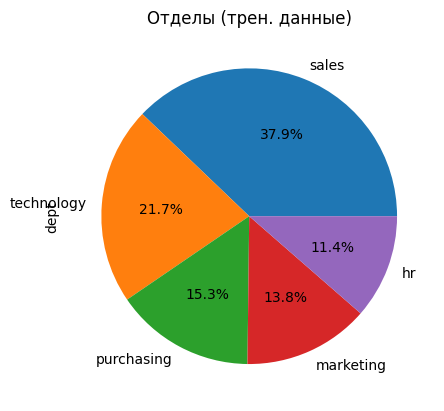

In [44]:
categ_analysis(train_job_satisf, 'dept')
plt.title('Отделы (трен. данные)')

Видим в целом обвчное распределение данных. Большинство сотрудников работают в отделе продаж. Меньше всего сотрудников в hr-отделе.

,dept
sales,763
technology,455
marketing,279
purchasing,273
hr,227


Text(0.5, 1.0, 'Отделы (тест. данные)')

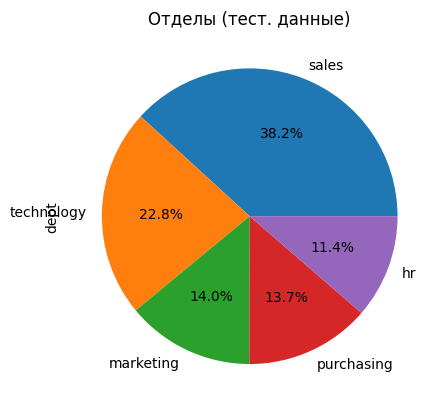

In [45]:
categ_analysis(test_features, 'dept')
plt.title('Отделы (тест. данные)')

Видим, что в тестовой выборке примерно такое же распределение по отделам. Единственное, местами поменялись отделы маркетинга и закупок.

Таким образом ```dept``` относится к категориальным признакам. К нему будет необходимо применить OneHotEncoder.

#### ```level```

,level
junior,1894
middle,1744
sinior,358


Text(0.5, 1.0, 'Уровень должности (трен. данные)')

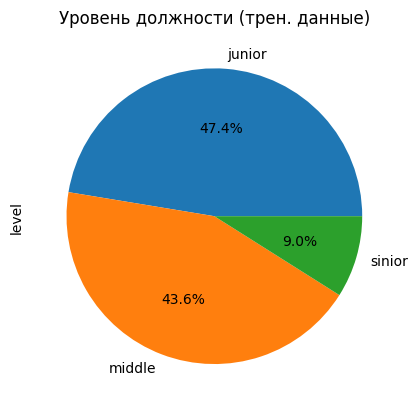

In [46]:
categ_analysis(train_job_satisf, 'level')
plt.title('Уровень должности (трен. данные)')

Видим, что большинство сотрудников являются специалистами уровня junior и middle. Всего 9% senior. Но посмотрим распределением по уровням в зависимости от отделов.

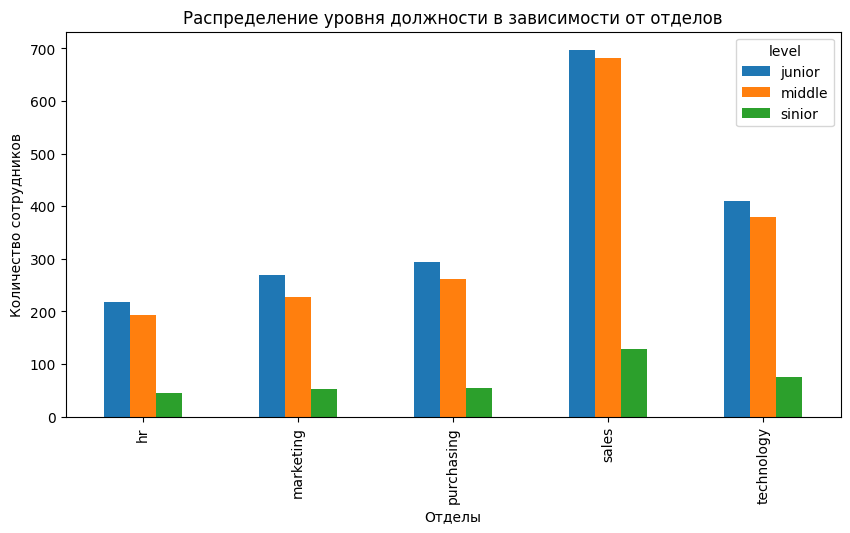

In [47]:
ax = train_job_satisf.pivot_table(index='dept', columns='level', values='salary', aggfunc='count').plot.bar(figsize=(10, 5))
plt.title('Распределение уровня должности в зависимости от отделов')
plt.xlabel('Отделы')
plt.ylabel('Количество сотрудников')
plt.show()

Видим, что во всех отделах больше всего джуниор специалистов, чуть меньше миддл и менее всего сеньор специалистов.

Посмотрим на тестовые данные.

,level
junior,974
middle,854
sinior,171


Text(0.5, 1.0, 'Уровень должности (тест. данные)')

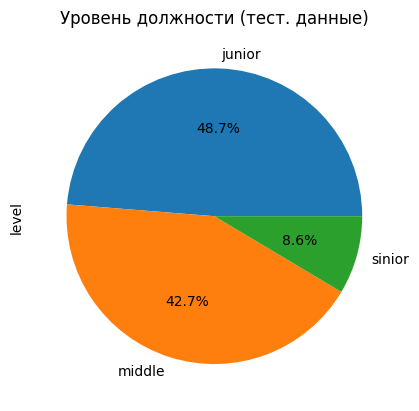

In [48]:
categ_analysis(test_features, 'level')
plt.title('Уровень должности (тест. данные)')

Видим аналогичную тренировачным данным ситуацию.

Так как есть возможность выстроить логичную связь между категориями (junior < middle < senior), то для кодирования этого столбца будем использовать OrdinalEncoder с указанием категорий.

#### ```workload```

,workload
medium,2066
low,1200
high,734


Text(0.5, 1.0, 'Уровень загруженности (трен. данные)')

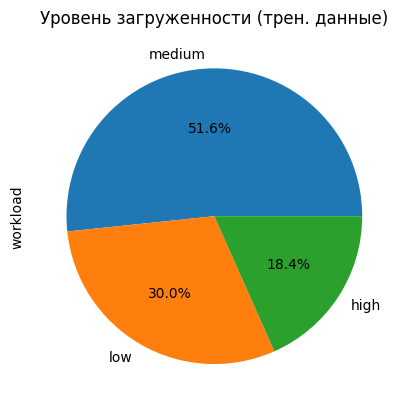

In [49]:
categ_analysis(train_job_satisf, 'workload')
plt.title('Уровень загруженности (трен. данные)')

Больше всего сотрудников (51.6%) загружены средне. Низкая загруженность у 30% процентов сотрудников, высокая у 18.4%.

Посмотрим на распределение загруженности в зависимости от уровня должности.

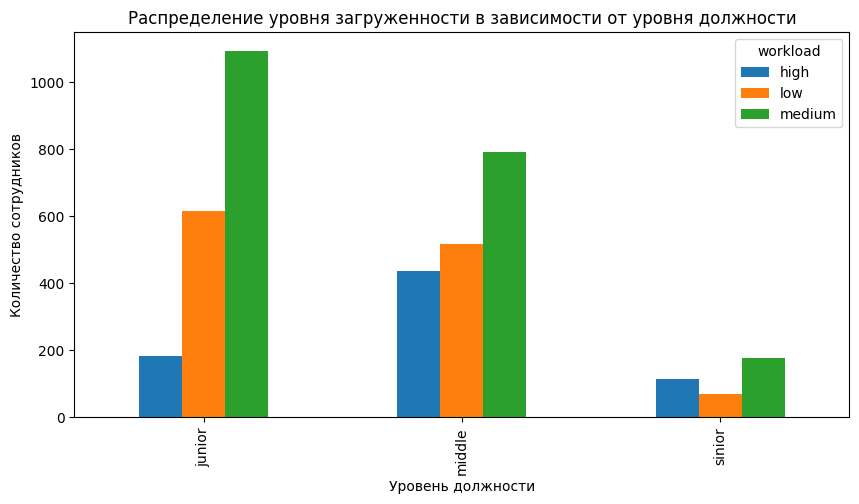

In [50]:
ax = (train_job_satisf.pivot_table(index='level', columns='workload', values='salary', aggfunc='count')
                                .plot.bar(figsize=(10, 5)))
plt.title('Распределение уровня загруженности в зависимости от уровня должности')
plt.xlabel('Уровень должности')
plt.ylabel('Количество сотрудников')
plt.show()

Видим, что для джуниор и миддл специалистов характерно то же распределение, что и по всей компании. Тогда как у сеньор специалистов на втором месте идет высокая загруженность, а на тратьем низкая, что логично, учитывая, что у сеньор специалистов больше ответственности, а значит и работы.

Рассмотрим распределение загруженности в зависимости от отделов.

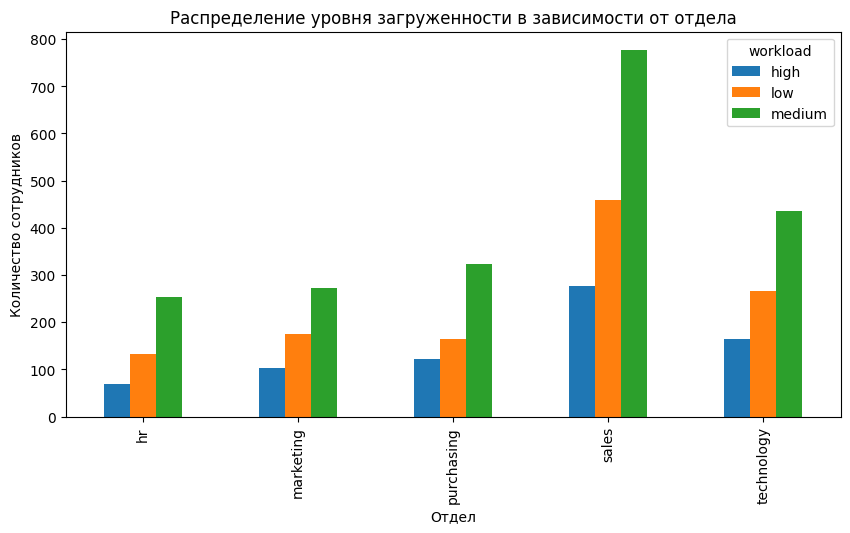

In [51]:
ax = (train_job_satisf.pivot_table(index='dept', columns='workload', values='salary', aggfunc='count')
                                        .plot.bar(figsize=(10, 5)))
plt.title('Распределение уровня загруженности в зависимости от отдела')
plt.xlabel('Отдел')
plt.ylabel('Количество сотрудников')
plt.show()

Видим, что по отделам ситуация в целом сохраняется, то есть во всех отделах больше всего средней загруженности и меньше всего высокой.

,workload
medium,1043
low,593
high,363


Text(0.5, 1.0, 'Уровень загруженности (тест. данные)')

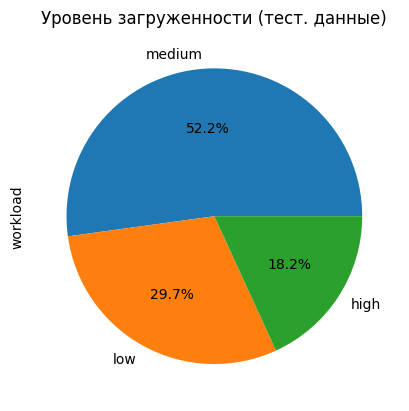

In [52]:
categ_analysis(test_features, 'workload')
plt.title('Уровень загруженности (тест. данные)')

На тестовых данных видим ту же картину, что и на тренировочных.

Здесь также можно определить, что low < medium < high, поэтому будет использовать OrdinalEncoder с указанием категорией.

#### ```employment_years```

Text(0.5, 1.0, 'Распределение длительности работы в компании (в годах)')

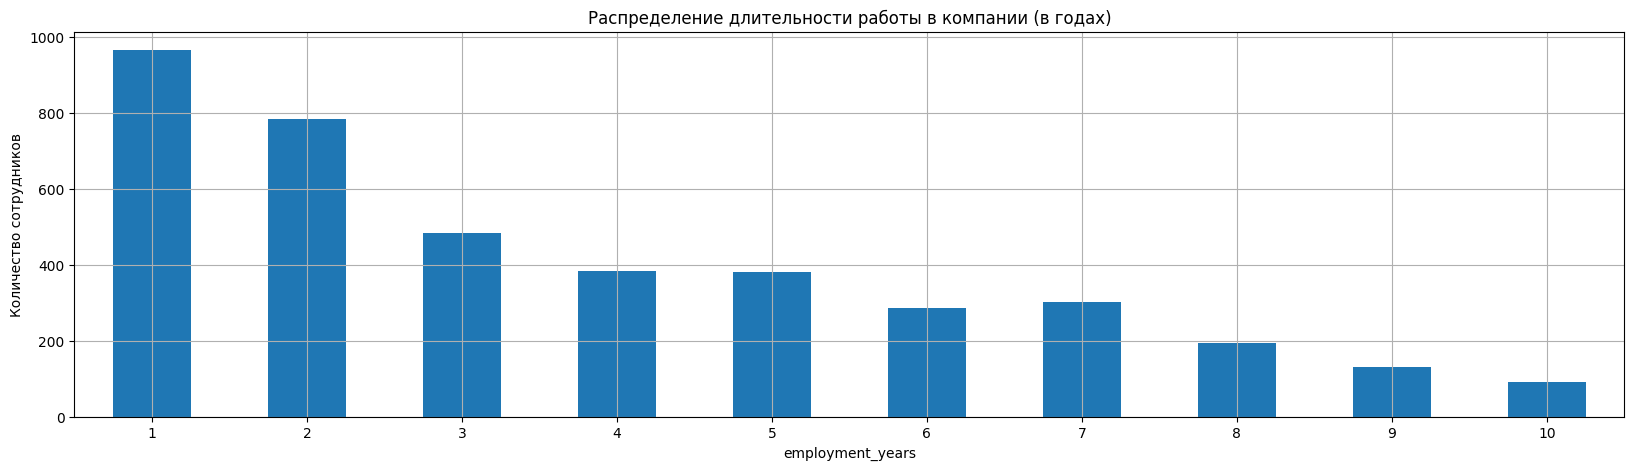

In [53]:
train_job_satisf.groupby('employment_years')['employment_years'].agg('count').plot.bar(rot=0, grid=True, figsize=(20, 5))
plt.ylabel('Количество сотрудников')
plt.title('Распределение длительности работы в компании (в годах)')

Большинство сотрудников компании работает в ней всего один год. С увеличением количества лет в компании, количество сотрудников уменьшается, что в целом логично. Также видим, что максимальное количество лет равняется 10.

Text(0.5, 1.0, 'Распределение длительности работы в компании (в годах)')

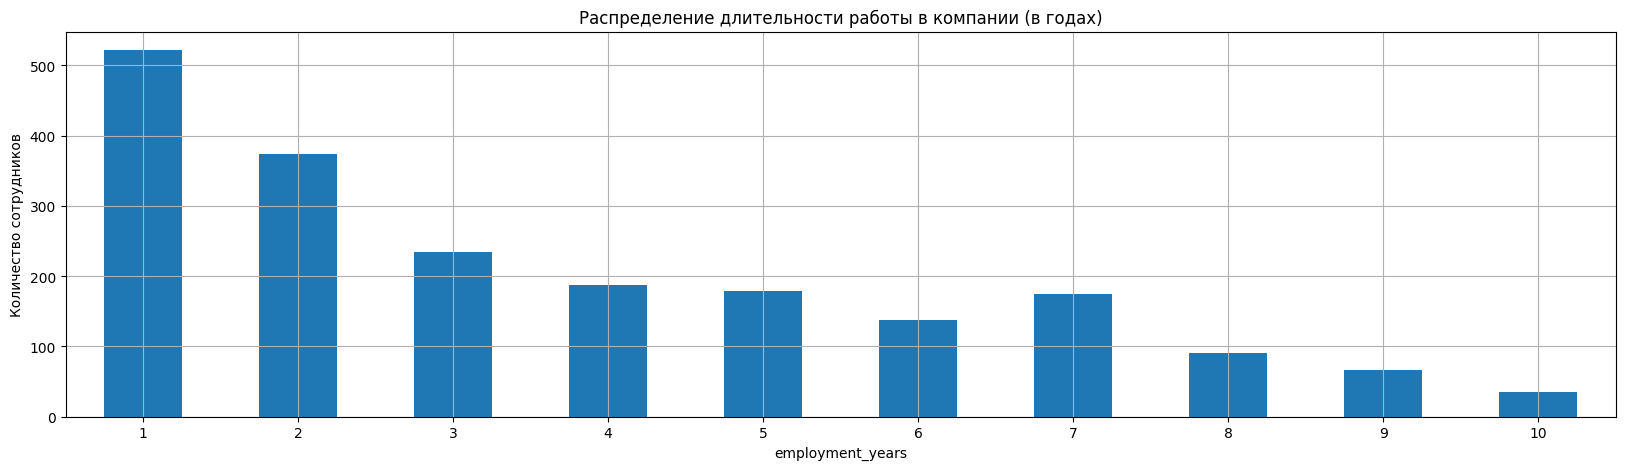

In [54]:
test_features.groupby('employment_years')['employment_years'].agg('count').plot.bar(rot=0, grid=True, figsize=(20, 5))
plt.ylabel('Количество сотрудников')
plt.title('Распределение длительности работы в компании (в годах)')

Для тренировочных данных видим такую же картину.

Количество лет в компании является непрерывным признаком, поэтому для кодировки будем использовать масштабирование.

#### ```last_year_promo```

,last_year_promo
no,3880
yes,120


Text(0.5, 1.0, 'Повышение за последний год (трен. данные)')

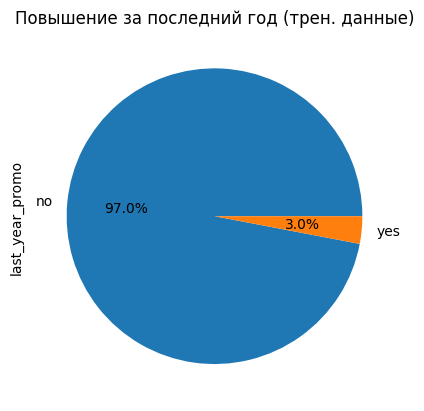

In [55]:
categ_analysis(train_job_satisf, 'last_year_promo')
plt.title('Повышение за последний год (трен. данные)')

Только у 3% сотрудников было повышение за последний год. Это может стать причиной низкой удовлетворенности сотрудников.

,last_year_promo
no,1937
yes,63


Text(0.5, 1.0, 'Повышение за последний год (тест. данные)')

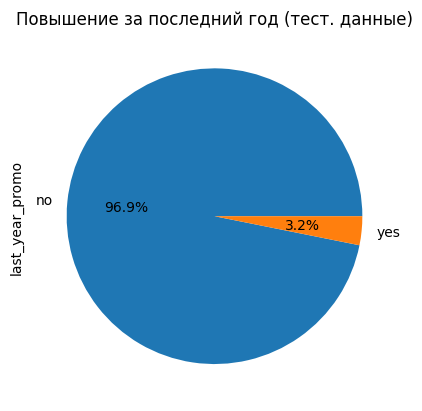

In [56]:
categ_analysis(test_features, 'last_year_promo')
plt.title('Повышение за последний год (тест. данные)')

Это категориальный признак. Будем использовать OneHotEncoder.

#### ```last_year_violations```

,last_year_violations
no,3441
yes,559


Text(0.5, 1.0, 'Нарушения за последний год (трен. данные)')

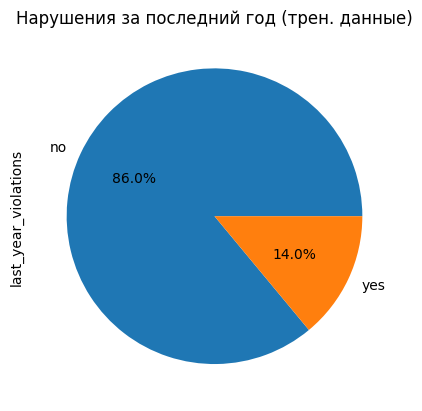

In [57]:
categ_analysis(train_job_satisf, 'last_year_violations')
plt.title('Нарушения за последний год (трен. данные)')

За последний год трудовой договор нарушали 14% сотрудников. Работадатель может считать нарушением не только какие-либо ошибки в работе, но и опоздания, поэтому трудно точно интерпретировать эти данные. Если каждую ошибку интерпретировать как нарушение трудового договора, это также может сказаться на удовлетворенности сотрудников работой.

,last_year_violations
no,1738
yes,262


Text(0.5, 1.0, 'Нарушения за последний год (тест. данные)')

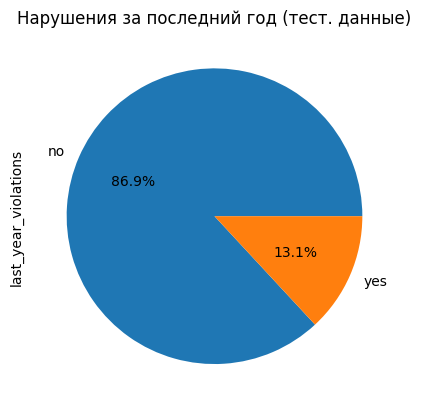

In [58]:
categ_analysis(test_features, 'last_year_violations')
plt.title('Нарушения за последний год (тест. данные)')

Это категориальный признак. Будем использовать OneHotEncoder.

#### ```supervisor_evaluation```

,supervisor_evaluation
4,1603
3,1263
5,546
2,387
1,201


Text(0.5, 1.0, 'Оценка от руководителя (трен. данные)')

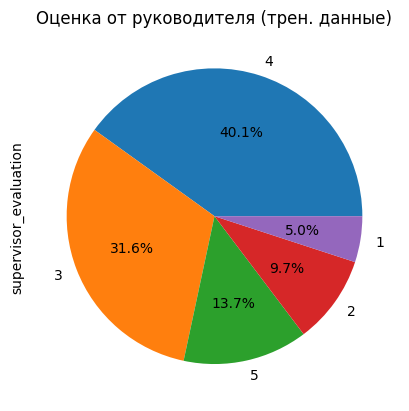

In [59]:
categ_analysis(train_job_satisf, 'supervisor_evaluation')
plt.title('Оценка от руководителя (трен. данные)')

Большинство сотрудников имеют оценку 4 (40.1%), далее оценка 3 (31.6%). На 5 наработало 13.7% сотрудников. На 1 и 2 14.7%. Большая разница между средними оценками (3 и 4) и остальными скорее всего вызвана нежеланием либо портить человеку жизнь, либо переоценивать его. Оценка от руководителя в любом случае субъективная величина.

,supervisor_evaluation
4,857
3,575
5,284
2,196
1,88


Text(0.5, 1.0, 'Оценка от руководителя (тест. данные)')

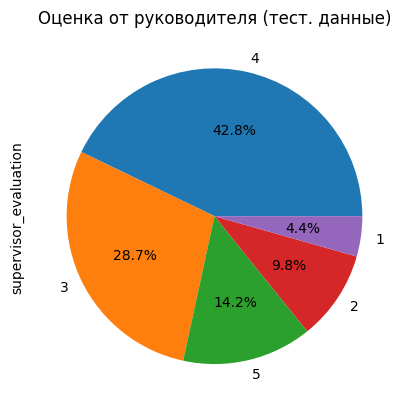

In [60]:
categ_analysis(test_features, 'supervisor_evaluation')
plt.title('Оценка от руководителя (тест. данные)')

По сути этот признак уже закодирован, поэтому для него необходимо будет только заполнить пропуски, если они есть.

#### ```salary```

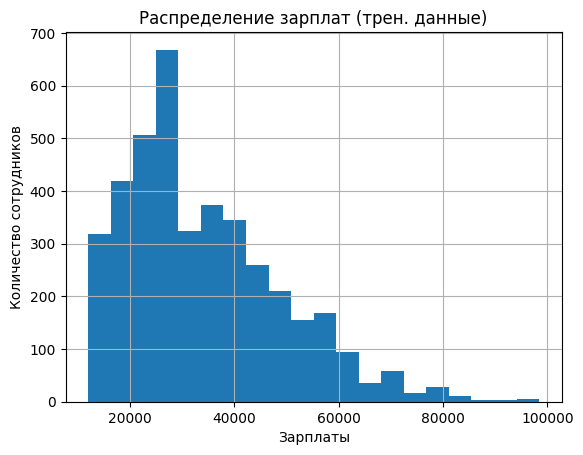

<AxesSubplot:>

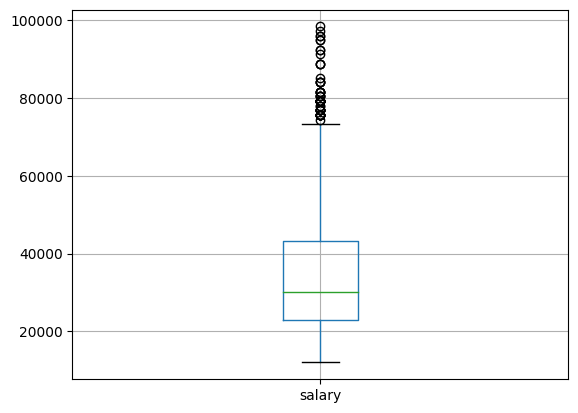

In [61]:
train_job_satisf['salary'].hist(bins=20)
plt.title('Распределение зарплат (трен. данные)')
plt.xlabel('Зарплаты')
plt.ylabel('Количество сотрудников')
plt.show()
train_job_satisf.boxplot('salary')

Медианная зарплата находится на уровне примерно 30 тысяч. Зарплаты более 75 тысяч можно считать большими.

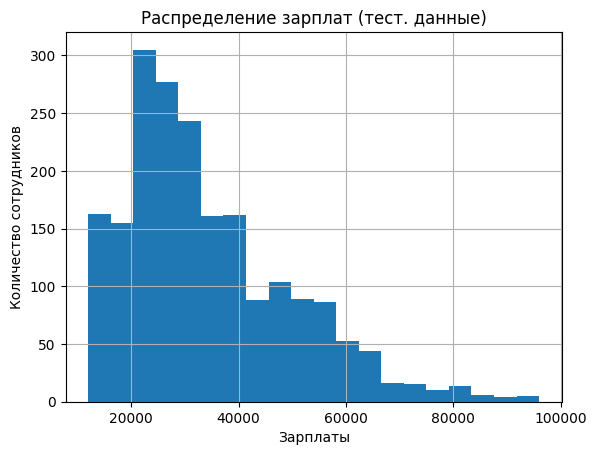

<AxesSubplot:>

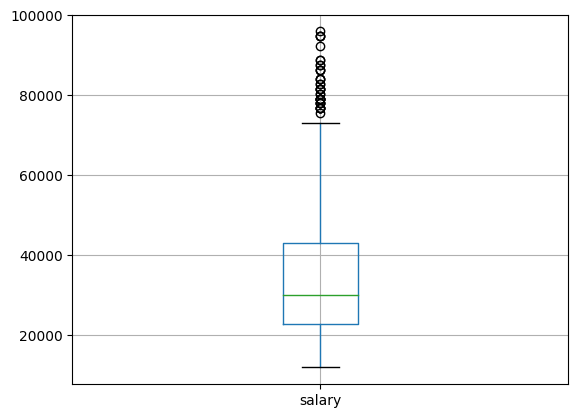

In [62]:
test_features['salary'].hist(bins=20)
plt.title('Распределение зарплат (тест. данные)')
plt.xlabel('Зарплаты')
plt.ylabel('Количество сотрудников')
plt.show()
test_features.boxplot('salary')

Зарплаты относятся к непрерывному числовом типу, поэтому будем использовать масштабирование для них.

#### ```job_satisfaction_rate```

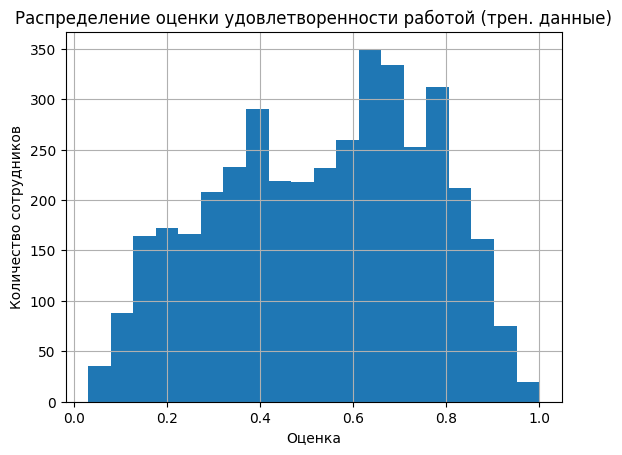

<AxesSubplot:>

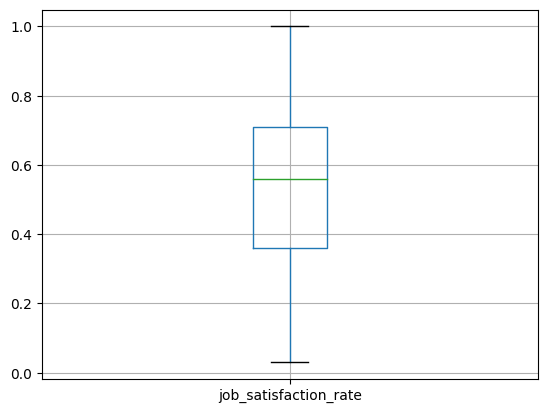

In [63]:
train_job_satisf['job_satisfaction_rate'].hist(bins=20)
plt.title('Распределение оценки удовлетворенности работой (трен. данные)')
plt.xlabel('Оценка')
plt.ylabel('Количество сотрудников')
plt.show()
train_job_satisf.boxplot('job_satisfaction_rate')

Медианное значение удовлетворенности находится в районе 0.55. То есть половина сотрудников не слишклм удовлетворена своей работой. Также видим на гистограмме, что после оценки 0.8 идет резкий спад, то есть оценки выше встречаются все реже.

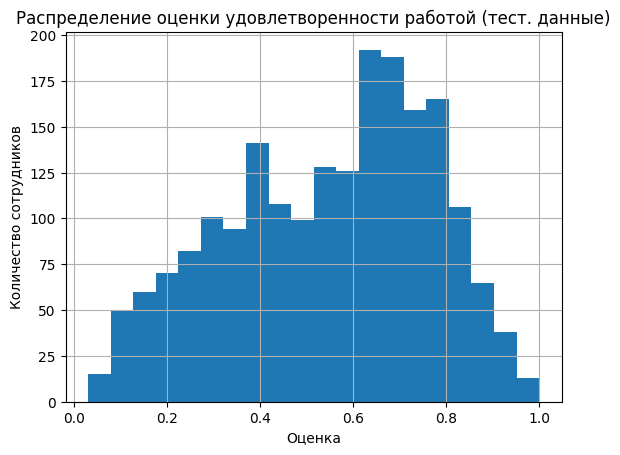

<AxesSubplot:>

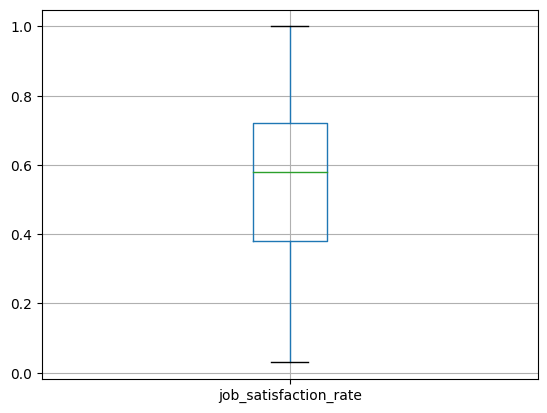

In [64]:
test_target['job_satisfaction_rate'].hist(bins=20)
plt.title('Распределение оценки удовлетворенности работой (тест. данные)')
plt.xlabel('Оценка')
plt.ylabel('Количество сотрудников')
plt.show()
test_target.boxplot('job_satisfaction_rate')

Оценка удовлетворенности является целевым признаком. Для нее нет необходимости проводить масштабирование.

В результате исследовательского анализа данных можно сказать, что данные предоставлены достаточно качественные. Какие-либо выбросы и аномалии отсутствуют. Также определили какая подготовка нужна для каждого столбца. Будем использовать:
- масштабирования для столбцов employment_years, salary;
- OrdinalEncoder для level, workload;
- OneHotEncoder для dept, last_year_promo, last_year_violations;

### Подготовка данных

In [65]:
# задаем наименования столбцов для соответствующей подготовки
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'salary']
others_columns = ['supervisor_evaluation']

In [66]:
# задаем пайплайн OneHotEncoder
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent', add_indicator=True)),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
    )

In [67]:
# задаем пайплайн OrdinalEncoder
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high']], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [68]:
# задаем пайплайн объединяющий преобразование признаков
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns),
     ('others', SimpleImputer(missing_values=np.nan, strategy='most_frequent'), others_columns)
    ], 
    remainder='passthrough'
)

Таким образом, подготовили пайплайны для подготовки данных перед обучением моделей. Использовали масштабирование, кодировщик OneHotEncoder и кодировщик OrdinalEncoder. Также в каждой пайплайне добавили заполнение пропусков. И для столбца, не требущего масштабирования или кодировки, также добавили заполнение пропусков.

### Обучение моделей

In [69]:
# задаем итоговый пайплайн
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [70]:
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(10, 20),
        'models__max_features': range(10, 20),
        'models__min_samples_split': range(10, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели SVR()
    {
        'models': [SVR()],
        'models__C': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели SGDRegressor()
    {
        'models': [SGDRegressor(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

В качестве метрики качества обучения по техническому заданию будем использовать метрику SMAPE - симметричное среднее абсолютное процентное отклонение.

In [71]:
# метрика SMAPE
def smape(y_true, y_pred):
    return (100 / len(y_true)) * sum(abs(y_true - y_pred) / ((abs(y_true) + abs(y_pred)) / 2))

In [72]:
# проверка с ручным расчетом
smape(np.array([1, 2, 3]), np.array([0, 1, 3]))

88.88888888888889

In [73]:
# в идеальном случае равна 0
smape(np.array([1, 2, 3]), np.array([1, 2, 3]))

0.0

In [74]:
# задаем метрику smape
smape_score = make_scorer(smape, greater_is_better=False)

Зададим переменные для признаков и таргетов тренировочных и тестовых выборок.

In [76]:
X_train = train_job_satisf.drop(['job_satisfaction_rate'], axis=1)
y_train = train_job_satisf['job_satisfaction_rate']
X_test = test_features
y_test = test_target['job_satisfaction_rate']

Обучим модели и выберем лучшую с помощью использования RandomizedSearchCV.

In [77]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_score,
    n_jobs=-1,
    n_iter=20,
    random_state=RANDOM_STATE
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violat

In [78]:
# сохраняем результаты работы моделей
result = pd.DataFrame(randomized_search.cv_results_)
result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__min_samples_split,param_models__max_features,param_models__max_depth,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.043330,0.006487,0.023158,0.008340,passthrough,16,18,12,"DecisionTreeRegressor(max_depth=15, max_featur...","{'preprocessor__num': 'passthrough', 'models__...",-15.683896,-14.893388,-15.236447,-15.222279,-14.013155,-15.009833,0.558171,16
1,0.046209,0.002047,0.027207,0.006060,MinMaxScaler(),11,13,14,"DecisionTreeRegressor(max_depth=15, max_featur...","{'preprocessor__num': MinMaxScaler(), 'models_...",-15.504066,-14.801335,-15.051178,-15.389568,-13.919570,-14.933143,0.564431,11
2,0.039908,0.007311,0.012603,0.011723,passthrough,16,17,13,"DecisionTreeRegressor(max_depth=15, max_featur...","{'preprocessor__num': 'passthrough', 'models__...",-15.598557,-14.845223,-15.197228,-15.266707,-13.818548,-14.945253,0.612062,12
3,0.047220,0.007796,0.012753,0.003106,StandardScaler(),15,16,13,"DecisionTreeRegressor(max_depth=15, max_featur...","{'preprocessor__num': StandardScaler(), 'model...",-15.523282,-14.635796,-15.250625,-15.187332,-13.934634,-14.906334,0.564892,10
4,0.041470,0.000203,0.014308,0.002397,StandardScaler(),16,14,15,"DecisionTreeRegressor(max_depth=15, max_featur...","{'preprocessor__num': StandardScaler(), 'model...",-15.428035,-14.863388,-15.113429,-15.281723,-13.802229,-14.897761,0.579051,9


In [79]:
# получим лучший пайплайн с лучшей моделью и преобразованием данных
best_pipeline = randomized_search.best_estimator_

In [80]:
# получим преобразование данных
best_preprocessor = best_pipeline['preprocessor']

In [81]:
# получим лучшую модель
best_model = best_pipeline.named_steps['models']
best_model

DecisionTreeRegressor(max_depth=15, max_features=10, min_samples_split=15,
                      random_state=42)

In [82]:
y_pred = randomized_search.predict(X_test)
print(f'Метрика SMAPE на тестовой выборке: {smape(y_test, y_pred)}')

Метрика SMAPE на тестовой выборке: 13.84844540027811


### Выводы

Посмотрим на результаты работы моделей.

In [83]:
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__min_samples_split,param_models__max_features,param_models__max_depth,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.043330,0.006487,0.023158,8.339847e-03,passthrough,16,18,12,"DecisionTreeRegressor(max_depth=15, max_featur...","{'preprocessor__num': 'passthrough', 'models__...",-15.683896,-14.893388,-15.236447,-15.222279,-14.013155,-15.009833,0.558171,16
1,0.046209,0.002047,0.027207,6.059810e-03,MinMaxScaler(),11,13,14,"DecisionTreeRegressor(max_depth=15, max_featur...","{'preprocessor__num': MinMaxScaler(), 'models_...",-15.504066,-14.801335,-15.051178,-15.389568,-13.919570,-14.933143,0.564431,11
2,0.039908,0.007311,0.012603,1.172282e-02,passthrough,16,17,13,"DecisionTreeRegressor(max_depth=15, max_featur...","{'preprocessor__num': 'passthrough', 'models__...",-15.598557,-14.845223,-15.197228,-15.266707,-13.818548,-14.945253,0.612062,12
3,0.047220,0.007796,0.012753,3.105867e-03,StandardScaler(),15,16,13,"DecisionTreeRegressor(max_depth=15, max_featur...","{'preprocessor__num': StandardScaler(), 'model...",-15.523282,-14.635796,-15.250625,-15.187332,-13.934634,-14.906334,0.564892,10
4,0.041470,0.000203,0.014308,2.397251e-03,StandardScaler(),16,14,15,"DecisionTreeRegressor(max_depth=15, max_featur...","{'preprocessor__num': StandardScaler(), 'model...",-15.428035,-14.863388,-15.113429,-15.281723,-13.802229,-14.897761,0.579051,9
5,0.039222,0.009542,0.012506,6.252766e-03,StandardScaler(),13,12,17,"DecisionTreeRegressor(max_depth=15, max_featur...","{'preprocessor__num': StandardScaler(), 'model...",-15.134616,-14.901920,-15.136579,-15.043666,-13.845378,-14.812432,0.491028,4
6,0.038990,0.007890,0.015897,2.199411e-03,MinMaxScaler(),15,15,11,"DecisionTreeRegressor(max_depth=15, max_featur...","{'preprocessor__num': MinMaxScaler(), 'models_...",-15.871189,-15.091963,-15.392126,-15.422959,-14.411275,-15.237902,0.482430,18
7,0.031236,0.001878,0.015206,8.489696e-04,passthrough,12,11,14,"DecisionTreeRegressor(max_depth=15, max_featur...","{'preprocessor__num': 'passthrough', 'models__...",-15.564389,-15.325328,-14.835441,-15.489931,-13.998653,-15.042748,0.580525,17
8,0.039788,0.007006,0.015626,9.536743e-08,StandardScaler(),10,11,11,"DecisionTreeRegressor(max_depth=15, max_featur...","{'preprocessor__num': StandardScaler(), 'model...",-16.050927,-15.160931,-15.126247,-15.904730,-14.518589,-15.352285,0.561437,19
9,0.043753,0.011694,0.015626,8.844012e-07,StandardScaler(),14,19,14,"DecisionTreeRegressor(max_depth=15, max_featur...","{'preprocessor__num': StandardScaler(), 'model...",-15.357672,-14.814256,-15.124628,-15.189504,-13.994823,-14.896177,0.483810,8


Лучше всех справилась модель DecisionTreeRegressor(max_depth=15, max_features=10, min_samples_split=15, random_state=42). Так как для нее результат метрики SMAPE получился равным 14.637, что видно по результатам работы, полученным из обученного пайплайна. На тестовой выборке результат лучшей модели также удовлетворителен и равен 13.848.

В результате получили обученную модель дерева решений, предсказывающую уровень удовлетворенности сотрудника по информации о нем.

Далее приступим ко второй части задачи - построению модели машинного обучения для предсказания того, уволится ли сотрудник.

## Задача 2

### Загрузка данных

In [84]:
train_quit = pd.read_csv('train_quit.csv')
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [85]:
test_features_quit = pd.read_csv('test_features.csv')
test_features_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [86]:
test_target_quit = pd.read_csv('test_target_quit.csv')
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Данные соответствуют своему описанию из постановки задачи. Имеем аналогичные признаки, что и в первой части задачи по предсказанию оценки удовлетворенности сотрудника. В качестве таргета имеет столбец ```quit```, в котором уход сотрудника отмечается как ```yes``` и не уход как ```no```.

### Предобработка данных

#### ```train_quit```

In [87]:
# общая информация 
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


Пропусков нет, типы столбцов соответствуют логически тем значениям, которые должны в них содержаться.

Проверим значения в столбцах, в том числе для поиска неявных дубликатов.

In [88]:
train_quit['dept'].unique()

array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

Неявных дубликатов или пустых строк нет.

In [89]:
train_quit['level'].unique()

array(['middle', 'junior', 'sinior'], dtype=object)

Неявные дубликаты отсутствуют.

In [90]:
train_quit['workload'].unique()

array(['high', 'medium', 'low'], dtype=object)

Неявные дубликаты отсутствуют.

In [91]:
train_quit['employment_years'].unique()

array([ 2,  5,  1,  8,  4,  7,  3,  9,  6, 10], dtype=int64)

Значения в признаке корректны.

In [92]:
train_quit['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

Неявные дубликаты отсутствуют.

In [93]:
train_quit['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

Неявные дубликаты отсутствуют.

In [94]:
train_quit['supervisor_evaluation'].unique()

array([4, 1, 3, 5, 2], dtype=int64)

Значения в признаке корректны.

In [95]:
train_quit['salary'].unique()

array([54000, 27600, 37200, 24000, 25200, 18000, 44400, 19200, 45600,
       57600, 33600, 16800, 22800, 26400, 82800, 32400, 39600, 30000,
       46800, 12000, 15600, 58800, 60000, 66000, 21600, 38400, 62400,
       40800, 56400, 34800, 28800, 52800, 20400, 36000, 61200, 48000,
       43200, 73200, 31200, 78000, 64800, 72000, 94800, 96000, 63600,
       79200, 55200, 42000, 49200, 50400, 14400, 13200, 51600, 67200,
       88800, 68400, 69600, 70800, 84000, 81600, 87600, 75600, 91200,
       76800, 74400, 80400, 85200, 86400, 92400], dtype=int64)

Значения в признаке корректны.

In [96]:
train_quit['quit'].unique()

array(['no', 'yes'], dtype=object)

Неявные дубликаты отсутствуют.

Проверим наличие полных дубликатов и дубликатов по id.

In [97]:
train_quit.duplicated().sum()

0

In [98]:
train_quit['id'].duplicated().sum()

0

Дубликатов нет.

In [99]:
# сделаем id индексом
train_quit = train_quit.set_index('id')
train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


Тренировочные данные предоставлены в корректном виде. Дополнительные манипуляции не требуются.

#### ```test_features_quit```

In [100]:
test_features_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


В тестовых входных признаках есть пропуски в столбцах ```dept, level```.

Теперь рассмотрим уникальные значения всех столбцов.

In [101]:
test_features_quit['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

Неявных дубликатов нет. Но заменим пустые строки на nan.

In [102]:
test_features_quit['dept'] = test_features_quit['dept'].replace(' ', np.nan)
test_features_quit['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan],
      dtype=object)

In [103]:
test_features_quit['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

Неявных дубликатов нет.

In [104]:
test_features_quit['workload'].unique()

array(['medium', 'low', 'high', ' '], dtype=object)

Неявных дубликатов нет. Заменим пустые строки на nan.

In [105]:
test_features_quit['workload'] = test_features_quit['workload'].replace(' ', np.nan)
test_features_quit['workload'].unique()

array(['medium', 'low', 'high', nan], dtype=object)

In [106]:
test_features_quit['employment_years'].unique()

array([ 2,  1,  5,  6,  3,  9,  7,  4,  8, 10], dtype=int64)

Значения в признаке корректны.

In [107]:
test_features_quit['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

Неявных дубликатов нет.

In [108]:
test_features_quit['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

Неявных дубликатов нет.

In [109]:
test_features_quit['supervisor_evaluation'].unique()

array([5, 4, 3, 1, 2], dtype=int64)

Значения в признаке корректны.

In [110]:
test_features_quit['salary'].unique()

array([28800, 30000, 19200, 40800, 42000, 26400, 49200, 62400, 14400,
       36000, 33600, 44400, 27600, 12000, 64800, 20400, 34800, 15600,
       18000, 50400, 31200, 51600, 16800, 43200, 52800, 32400, 37200,
       58800, 24000, 21600, 48000, 45600, 25200, 63600, 61200, 56400,
       38400, 46800, 55200, 13200, 39600, 54000, 57600, 68400, 22800,
       72000, 81600, 60000, 66000, 67200, 70800, 76800, 79200, 69600,
       94800, 82800, 80400, 87600, 86400, 96000, 78000, 75600, 73200,
       84000, 88800, 92400], dtype=int64)

Значения в признаке корректны.

Проверим полные дубликаты и дубликаты по id.

In [111]:
test_features_quit.duplicated().sum()

0

In [112]:
test_features_quit['id'].duplicated().sum()

0

Дубликатов нет.

In [113]:
# сделаем id индексом
test_features_quit = test_features_quit.set_index('id')
test_features_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


#### ```test_target_quit```

In [114]:
# общая информация
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Пропусков нет.

In [115]:
test_target_quit['quit'].unique()

array(['yes', 'no'], dtype=object)

Неявных дубликатов нет.

Проверим лубликаты по id.

In [116]:
test_target_quit['id'].duplicated().sum()

0

Дубликатов нет.

In [117]:
# сделаем id индексом
test_target_quit = test_target_quit.set_index('id')
test_target_quit.head()

,quit
id,
999029,yes
372846,no
726767,no
490105,no
416898,yes


Проверим совпадает ли порядок индексов в датафреймах ```test_features_quit``` и ```test_target_quit```.

In [118]:
(test_features_quit.index == test_target_quit.index).sum()

0

Порядок не совпадает. Поставим индексы в соответствие.

In [119]:
test_target_quit = test_target_quit.reindex(test_features_quit.index)
test_target_quit.head()

,quit
id,
485046,no
686555,no
467458,no
418655,no
789145,no


In [120]:
(test_features_quit.index == test_target_quit.index).sum()

2000

Теперь порядок в индексах совпадает.

Проверим нет ли пересечения в индексах тестовых и тренировочных данных.

In [121]:
(train_quit.index.isin(test_features_quit.index)).sum()

0

Пересечения в индексах нет.

В результате предобработки данных поставили порядок строк в тестовых данных в соответствие, заменили пустые строки на nan, проверили наличие дубликатов, а также, что сотрудники в тренировочной и тестовой выборке разные.

### Исследовательский анализ данных

Проведем исследовательский анализ данных.

#### ```dept```

,dept
sales,1438
technology,928
purchasing,588
marketing,582
hr,464


Text(0.5, 1.0, 'Отделы (трен. данные)')

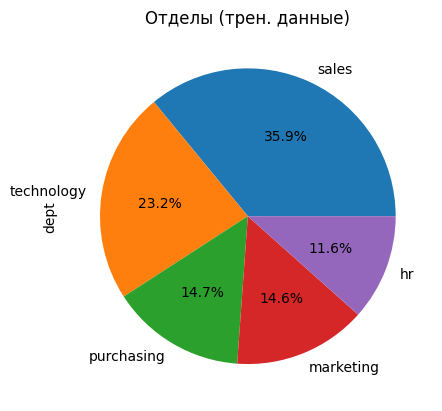

In [122]:
categ_analysis(train_quit, 'dept')
plt.title('Отделы (трен. данные)')

Видим ситуацию, аналогичную данным рассмотренным раннее. Больше всего сотрудников работает в отделе продаж. Затем идет технологический отдел, отдел закупок, маркетинговый отдел и hr-отдел.

,dept
sales,763
technology,455
marketing,279
purchasing,273
hr,227


Text(0.5, 1.0, 'Отделы (тест. данные)')

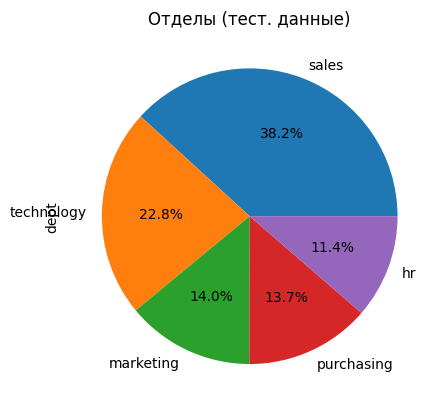

In [123]:
categ_analysis(test_features_quit, 'dept')
plt.title('Отделы (тест. данные)')

Для тестовых данных наблюдаем подобное же распределение сотрудников по отделам. Есть небольшое различие в том, что маркетинг немного опередил закупки. Однако, в данном случае это не важно. Так как у нас изначально разделены тренировочные и тестовые данные, и дисбаланс важен только для тренировочных. Он будет учтен в пайплайне.

#### ```level```

,level
junior,1949
middle,1694
sinior,357


Text(0.5, 1.0, 'Уровень должности (трен. данные)')

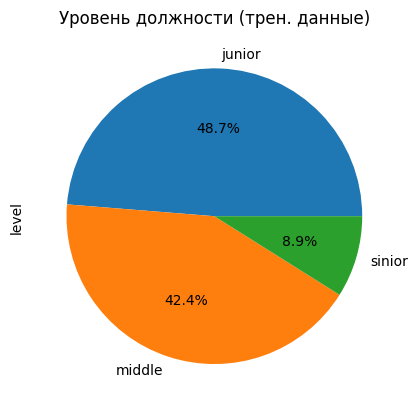

In [124]:
categ_analysis(train_quit, 'level')
plt.title('Уровень должности (трен. данные)')

Наибольшее количество сотруднкиов имеют должность уровня джуниор и миддл. Всего 8.9% сотрудников уровня сеньор.

,level
junior,974
middle,854
sinior,171


Text(0.5, 1.0, 'Уровень должности (тест. данные)')

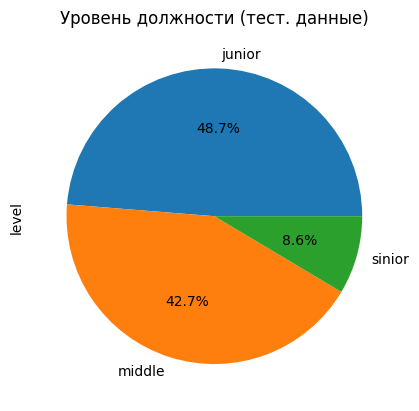

In [125]:
categ_analysis(test_features_quit, 'level')
plt.title('Уровень должности (тест. данные)')

#### ```workload```

,workload
medium,2118
low,1208
high,674


Text(0.5, 1.0, 'Уровень загруженности (трен. данные)')

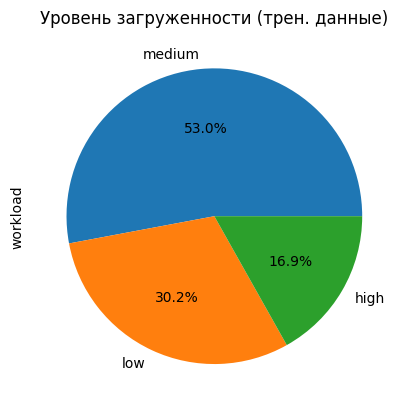

In [126]:
categ_analysis(train_quit, 'workload')
plt.title('Уровень загруженности (трен. данные)')

Большинство сотрудников (53%) имеют среднюю загруженность. Низкую загруженность имеют 30.2% сотрудников, а высокую 16.9%.

,workload
medium,1043
low,593
high,363


Text(0.5, 1.0, 'Уровень загруженности (тест. данные)')

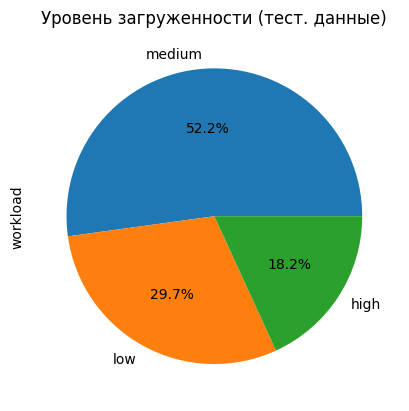

In [127]:
categ_analysis(test_features_quit, 'workload')
plt.title('Уровень загруженности (тест. данные)')

#### ```employment_years```

Text(0.5, 1.0, 'Распределение длительности работы в компании (в годах)')

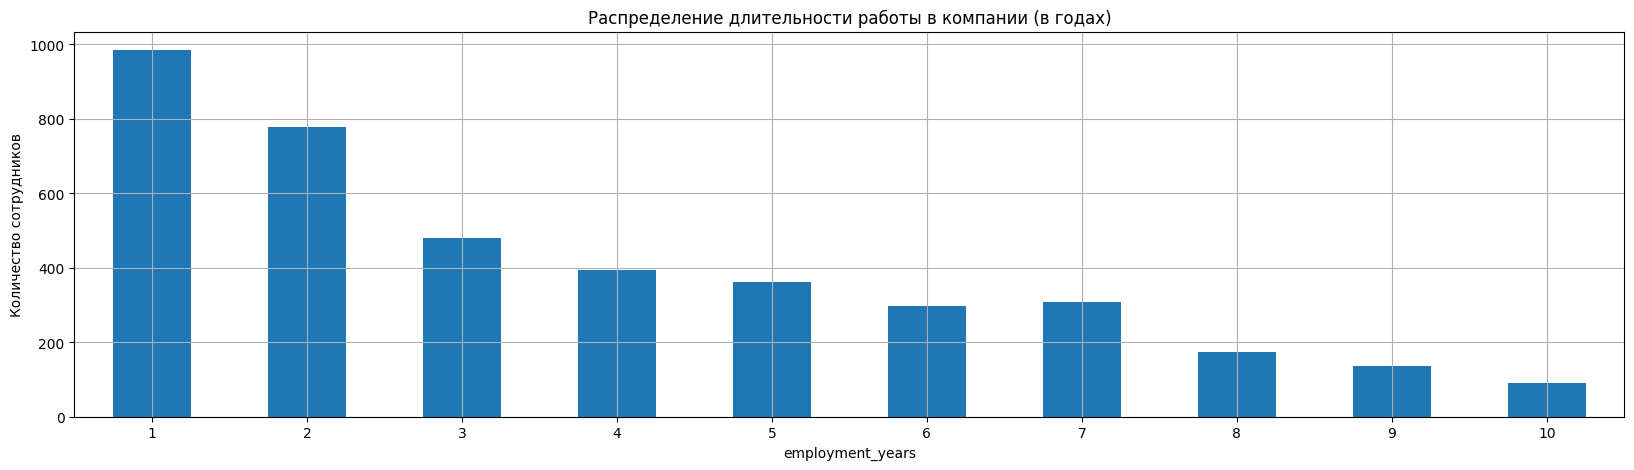

In [128]:
train_quit.groupby('employment_years')['employment_years'].agg('count').plot.bar(rot=0, grid=True, figsize=(20, 5))
plt.ylabel('Количество сотрудников')
plt.title('Распределение длительности работы в компании (в годах)')

Большинство сотрудников компании работает в ней всего один год. С увеличением количества лет в компании, количество сотрудников уменьшается, что в целом логично. Также видим, что максимальное количество лет равняется 10.

#### ```last_year_promo```

,last_year_promo
no,3887
yes,113


Text(0.5, 1.0, 'Повышение за последний год (трен. данные)')

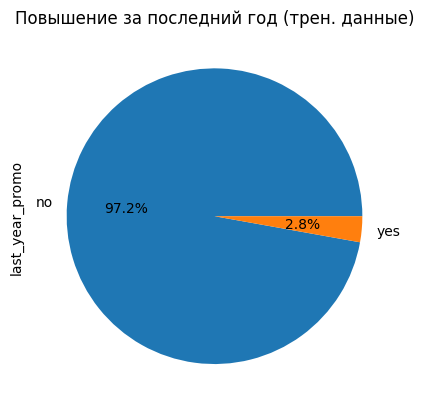

In [129]:
categ_analysis(train_quit, 'last_year_promo')
plt.title('Повышение за последний год (трен. данные)')

Только у 2.8% сотрудников было повышение за последний год. Это может стать причиной низкой удовлетворенности сотрудников.

#### ```last_year_violations```

,last_year_violations
no,3455
yes,545


Text(0.5, 1.0, 'Нарушения за последний год (трен. данные)')

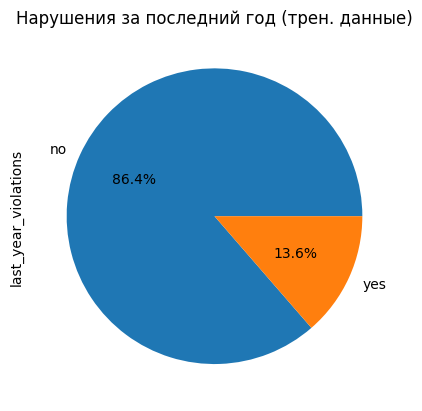

In [130]:
categ_analysis(train_quit, 'last_year_violations')
plt.title('Нарушения за последний год (трен. данные)')

За последний год трудовой договор нарушали 13.6% сотрудников. Работадатель может считать нарушением не только какие-либо ошибки в работе, но и опоздания, поэтому трудно точно интерпретировать эти данные. Если каждую ошибку интерпретировать как нарушение трудового договора, это также может сказаться на удовлетворенности сотрудников работой.

,last_year_violations
no,1738
yes,262


Text(0.5, 1.0, 'Нарушения за последний год (тест. данные)')

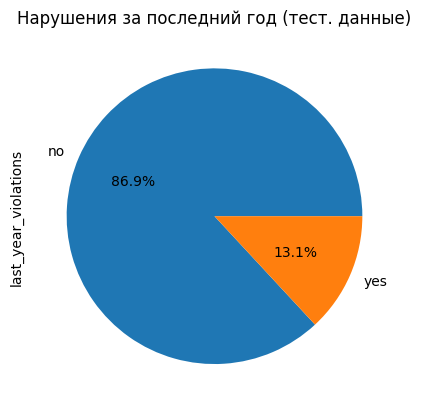

In [131]:
categ_analysis(test_features_quit, 'last_year_violations')
plt.title('Нарушения за последний год (тест. данные)')

#### ```supervisor_evaluation```

,supervisor_evaluation
4,1654
3,1233
5,520
2,391
1,202


Text(0.5, 1.0, 'Оценка от руководителя (трен. данные)')

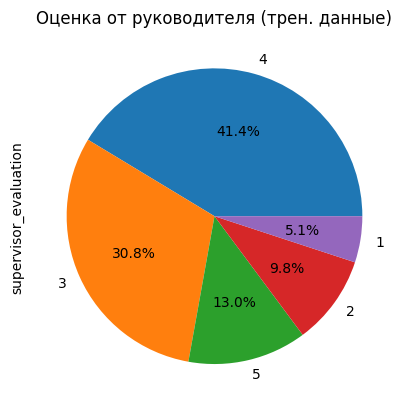

In [132]:
categ_analysis(train_quit, 'supervisor_evaluation')
plt.title('Оценка от руководителя (трен. данные)')

Большинство сотрудников имеют оценку 4 (41.4%), далее оценка 3 (30.8%). На 5 наработало 13% сотрудников. На 1 и 2 14.9%. Большая разница между средними оценками (3 и 4) и остальными скорее всего вызвана нежеланием либо портить человеку жизнь, либо переоценивать его. Оценка от руководителя в любом случае субъективная величина.

,supervisor_evaluation
4,857
3,575
5,284
2,196
1,88


Text(0.5, 1.0, 'Оценка от руководителя (тест. данные)')

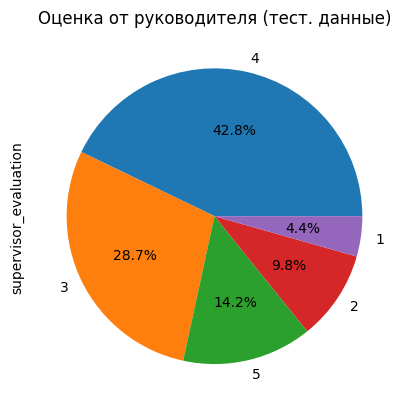

In [133]:
categ_analysis(test_features_quit, 'supervisor_evaluation')
plt.title('Оценка от руководителя (тест. данные)')

#### ```salary```

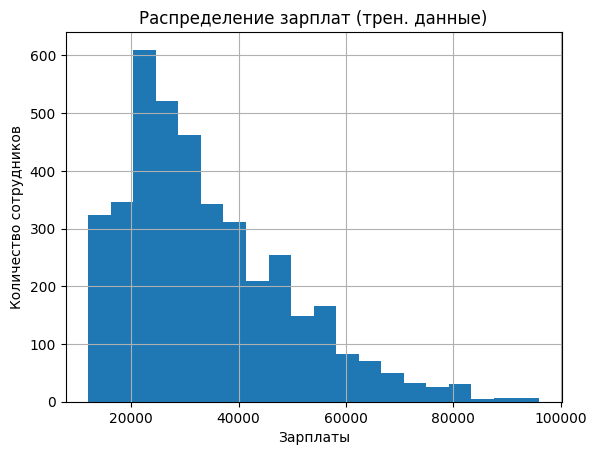

<AxesSubplot:>

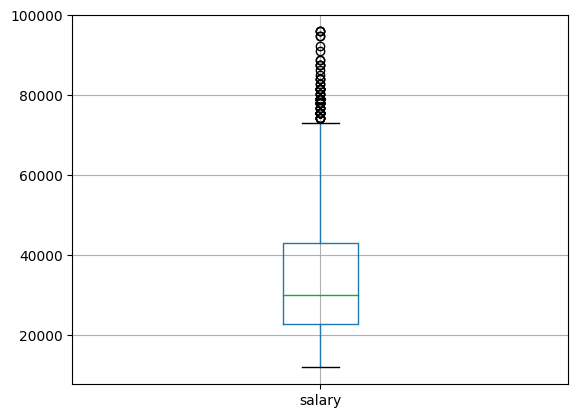

In [134]:
train_quit['salary'].hist(bins=20)
plt.title('Распределение зарплат (трен. данные)')
plt.xlabel('Зарплаты')
plt.ylabel('Количество сотрудников')
plt.show()
train_quit.boxplot('salary')

Медианная зарплата находится на уровне примерно 30 тысяч. Зарплаты более 75 тысяч можно считать большими.

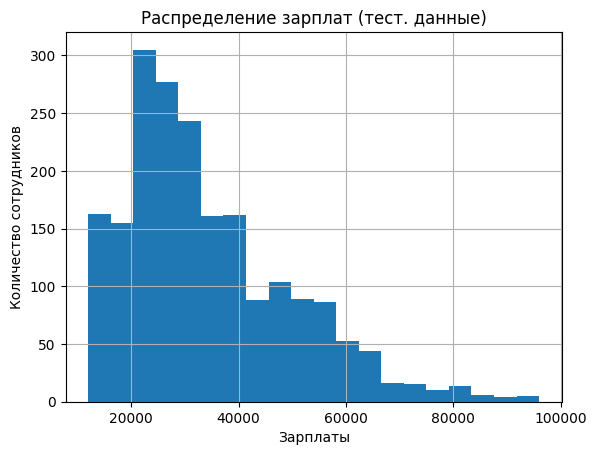

<AxesSubplot:>

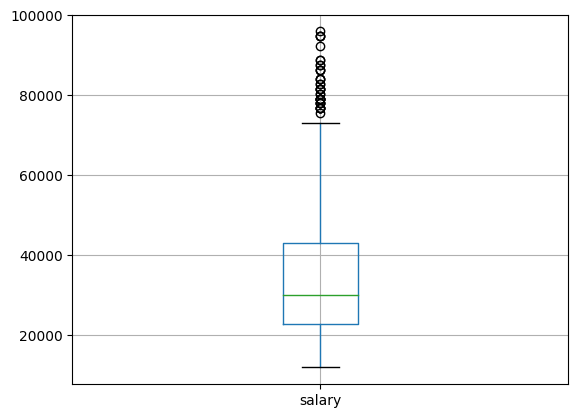

In [135]:
test_features_quit['salary'].hist(bins=20)
plt.title('Распределение зарплат (тест. данные)')
plt.xlabel('Зарплаты')
plt.ylabel('Количество сотрудников')
plt.show()
test_features_quit.boxplot('salary')

#### ```quit```

,quit
no,2872
yes,1128


Text(0.5, 1.0, 'Увольнение (трен. данные)')

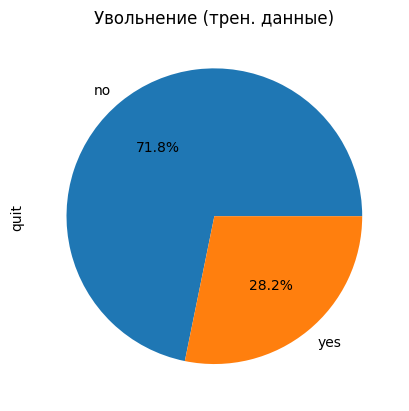

In [136]:
categ_analysis(train_quit, 'quit')
plt.title('Увольнение (трен. данные)')

Видим, что 28.2% сотрудников компании уволились. Много это или мало зависит от того чем компания занимается. В торговле отток в 20-30% нормальное явление. Однако, в любом случае, скорее всего, его необходимо уменьшить.

,quit
no,1436
yes,564


Text(0.5, 1.0, 'Увольнение (тест. данные)')

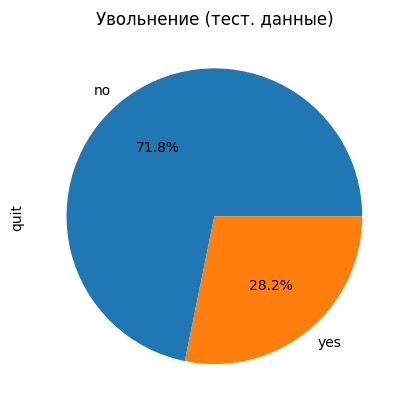

In [137]:
categ_analysis(test_target_quit, 'quit')
plt.title('Увольнение (тест. данные)')

#### Портрет уволившегося сотрудника

Посмотрим распределение по отделам уволившихся сотрудников.

,dept
sales,407
technology,276
purchasing,166
marketing,163
hr,116


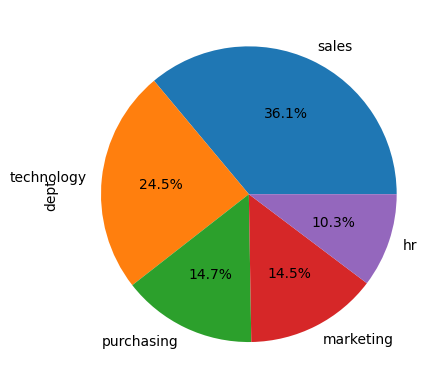

In [138]:
categ_analysis(train_quit.query('quit == "yes"'), 'dept')

Видим, что в целом отношения по отделам среди уволившихся остались такими же, как и по всем сотрудникам. То есть большее количество уволившихся сотрудников отдела продаж означает лишь только то, что в этом отделе изначально больше всего сотрудников.

Теперь посмотрим на уровень загруженности уволившихся сотрудников.

,workload
low,519
medium,488
high,121


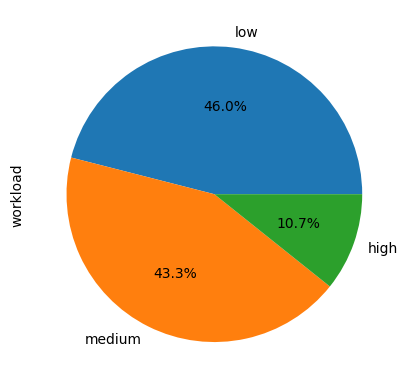

In [139]:
categ_analysis(train_quit.query('quit == "yes"'), 'workload')

Распределение уровня загруженности также соответствует тому, который видели для всех сотрудников.

Посмотрим на уровень должности уволившихся сотрудников.

,level
junior,1003
middle,108
sinior,17


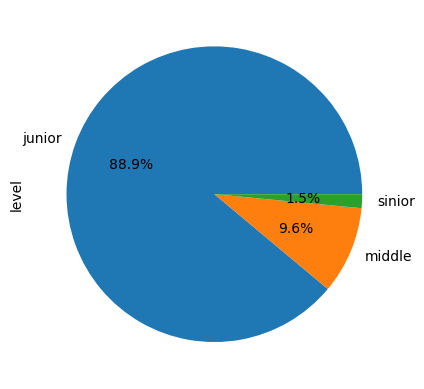

In [140]:
categ_analysis(train_quit.query('quit == "yes"'), 'level')

Таким образом подавляющее большинство уволившихся сотрудников занимали джуниор должности. Скорее всего, это связано с зарабатной платой. Сравним среднюю зарплату уволившихся и оставшихся сотрудников.

In [141]:
print('Средняя зарплата уволившихся - ', train_quit.query('quit == "yes"')['salary'].mean())
print(f'Средняя зарплата оставшихся - ', train_quit.query('quit == "no"')['salary'].mean())

Средняя зарплата уволившихся -  23885.106382978724
Средняя зарплата оставшихся -  37702.22841225627


Средняя зарплата уволившихся сотрудников меньше средней зарплаты оставшихся на 14 тысяч. Теперь сравним зарплаты ушедших и оставшихся джуниор специалистов.

In [142]:
print('Средняя зарплата уволившихся джуниор - ', train_quit.query('quit == "yes" and level == "junior"')['salary'].mean())
print(f'Средняя зарплата оставшихся джуниор - ', train_quit.query('quit == "no" and level == "junior"')['salary'].mean())

Средняя зарплата уволившихся джуниор -  22508.075772681954
Средняя зарплата оставшихся джуниор -  25661.733615221987


Разница существенно меньше, всего 3 тысячи, но она есть.

Теперь посмотрим на оценку руководителя сотрудников ушедших и оставшихся.

,supervisor_evaluation
3,523
4,286
2,164
1,95
5,60


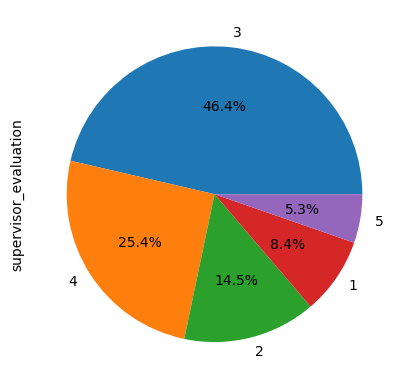

In [143]:
categ_analysis(train_quit.query('quit == "yes"'), 'supervisor_evaluation')

,supervisor_evaluation
4,1368
3,710
5,460
2,227
1,107


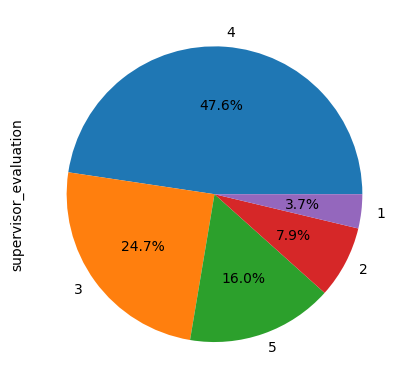

In [144]:
categ_analysis(train_quit.query('quit == "no"'), 'supervisor_evaluation')

Получается, что среди ушедших больше тех, кого оценили в 1 и 2 по сравнению с оставшимися.

Также сравним ситуацию с нарушениями.

,last_year_violations
no,900
yes,228


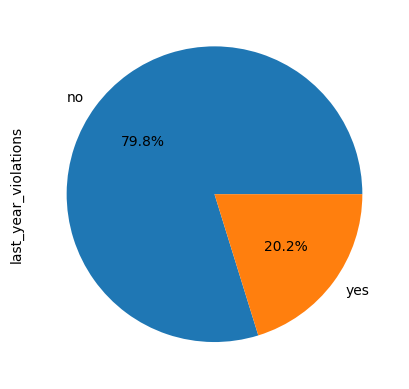

In [145]:
categ_analysis(train_quit.query('quit == "yes"'), 'last_year_violations')

,last_year_violations
no,2555
yes,317


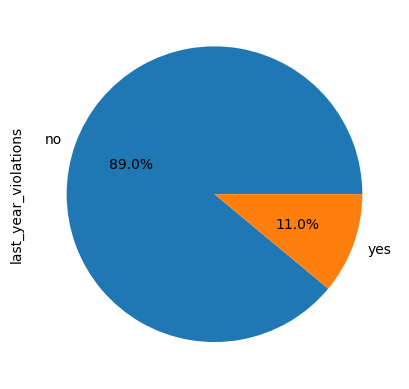

In [146]:
categ_analysis(train_quit.query('quit == "no"'), 'last_year_violations')

Видим, что нарушающих среди ушедших больше чем среди оставшихся.

Text(0.5, 1.0, 'Распределение длительности работы в компании (в годах) для уволившихся сотрудников')

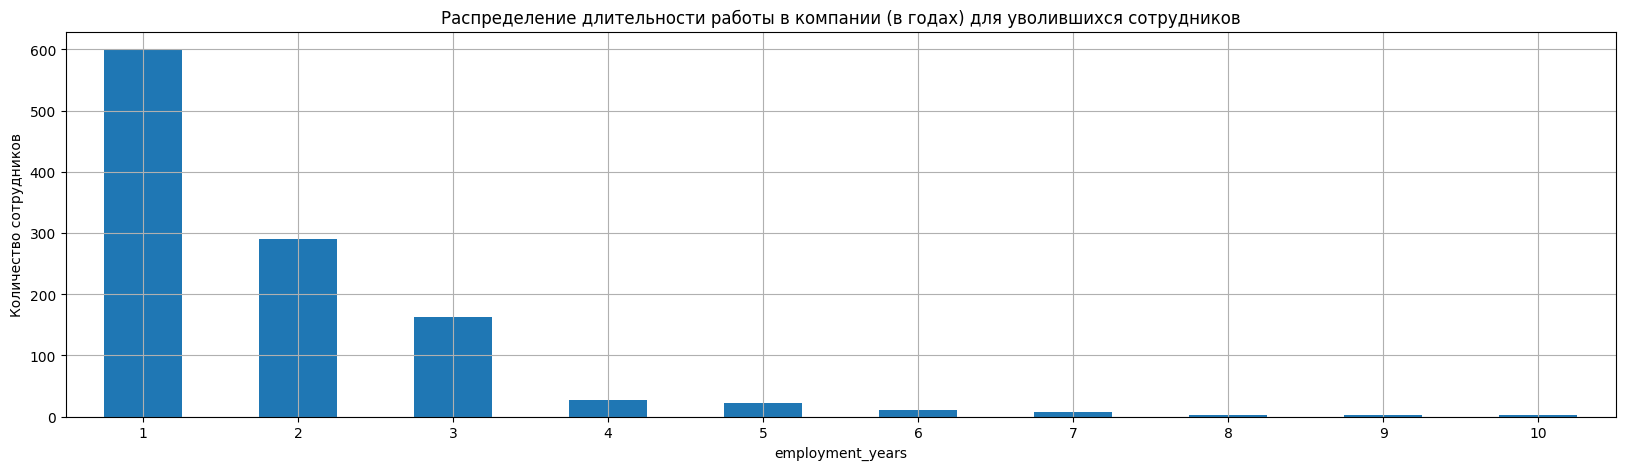

In [147]:
train_quit.query('quit == "yes"').groupby('employment_years')['employment_years'].agg('count').plot.bar(rot=0, grid=True, figsize=(20, 5))
plt.ylabel('Количество сотрудников')
plt.title('Распределение длительности работы в компании (в годах) для уволившихся сотрудников')

Text(0.5, 1.0, 'Распределение длительности работы в компании (в годах) для оставшихся сотрудников')

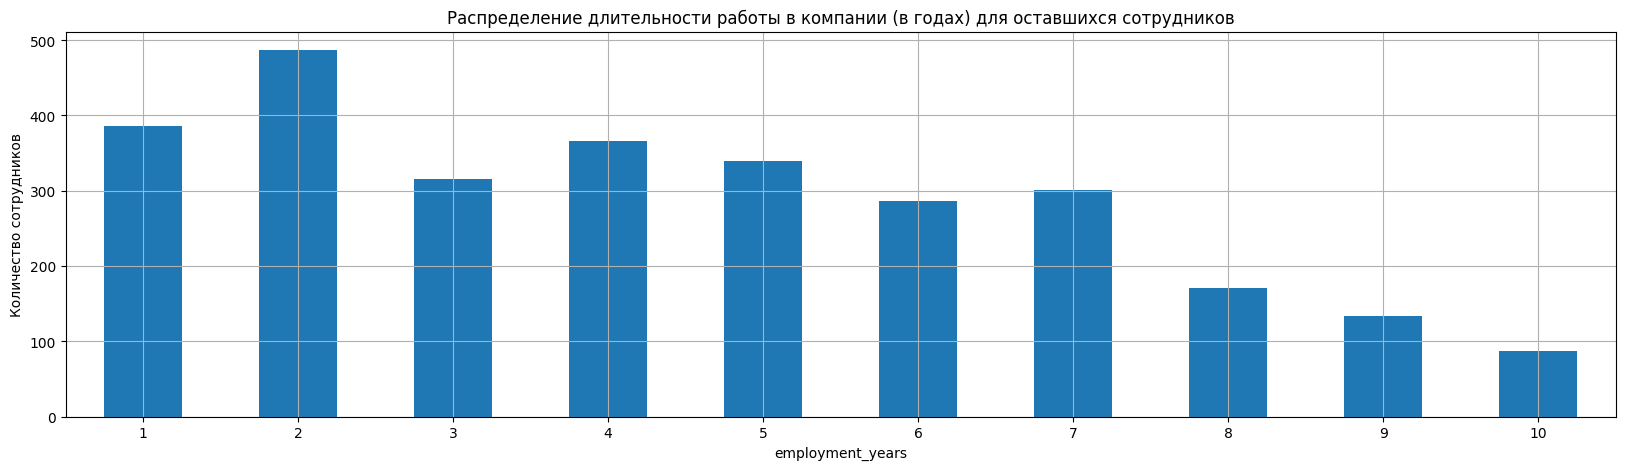

In [148]:
train_quit.query('quit == "no"').groupby('employment_years')['employment_years'].agg('count').plot.bar(rot=0, grid=True, figsize=(20, 5))
plt.ylabel('Количество сотрудников')
plt.title('Распределение длительности работы в компании (в годах) для оставшихся сотрудников')

Таким образом, видим, что большинство уволившихся сотрудников уходят, не проработав 4 лет.

Получается, что уволившиеся сотрудники это в первую очередь джуниор специалисты с невысоким окладом и большим процентом сотрудников с нарушениями. Видим, что руководители оценивают уволившихся сотрудников хуже, чем оставшихся. Также уволившиеся перед своим уходом работают в основном не дольше 3 лет.

#### ```job_satisfaction_rate```

По утверждению аналитиков уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это.

In [149]:
test_quit = test_features_quit.join(test_target_quit, on='id', how='inner')
# выведем количество строк, чтобы проверить, что объединение прошло без потерь
display(test_features_quit.shape[0])
display(test_target_quit.shape[0])
test_quit.shape[0]

2000

2000

2000

In [150]:
test_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,no
686555,hr,junior,medium,1,no,no,4,30000,no
467458,sales,middle,low,5,no,no,4,19200,no
418655,sales,middle,low,6,no,no,4,19200,no
789145,hr,middle,medium,5,no,no,5,40800,no


In [151]:
# откуда будем брать оценку работы
test_target.head()

,job_satisfaction_rate
id,
485046,0.79
686555,0.72
467458,0.64
418655,0.60
789145,0.75


In [152]:
test_quit = test_quit.join(test_target, on='id', how='inner')
display(test_quit.shape[0])
test_quit.head()

2000

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,no,0.79
686555,hr,junior,medium,1,no,no,4,30000,no,0.72
467458,sales,middle,low,5,no,no,4,19200,no,0.64
418655,sales,middle,low,6,no,no,4,19200,no,0.60
789145,hr,middle,medium,5,no,no,5,40800,no,0.75


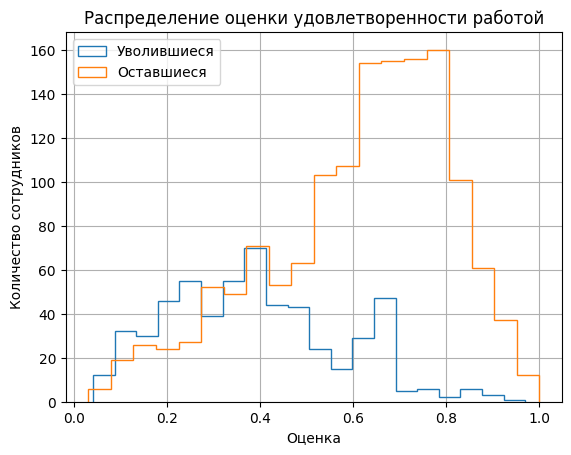

In [153]:
test_quit.query('quit == "yes"')['job_satisfaction_rate'].hist(bins=20, histtype='step')
test_quit.query('quit == "no"')['job_satisfaction_rate'].hist(bins=20, histtype='step')
plt.legend(['Уволившиеся', 'Оставшиеся'], loc='upper left')
plt.title('Распределение оценки удовлетворенности работой')
plt.xlabel('Оценка')
plt.ylabel('Количество сотрудников')
plt.show()

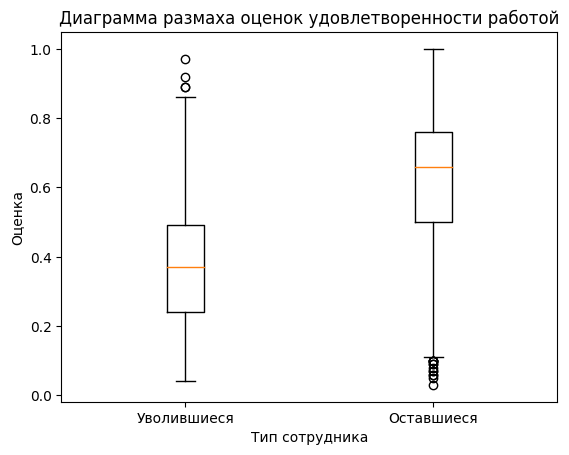

In [154]:
job_satisf_dict = {'Уволившиеся':test_quit.query('quit == "yes"')['job_satisfaction_rate'], 
                   'Оставшиеся':test_quit.query('quit == "no"')['job_satisfaction_rate']}
plt.boxplot(job_satisf_dict.values(), labels=job_satisf_dict.keys())
plt.title('Диаграмма размаха оценок удовлетворенности работой')
plt.ylabel('Оценка')
plt.xlabel('Тип сотрудника')
plt.show()

Видим, что медианная оценка ушедших немного меньше 0.4, тогда как медианная оценка оставшихся примерно равна 0.65. Также в случае ушедших высокие оценки (выше 0.8) считаются выбросами. В случае оставшихся наоборот низкие оценки (ниже 0.1) считаются выбросами. Таким образом, действительно уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник.

### Добавление ```job_satisfaction_rate```

Необходимо добавить ```job_satisfaction_rate``` в тренировочные данные. Уберем из них столбец ```quit``` и предскажем оценку.

In [155]:
train_no_quit = train_quit.drop('quit', axis=1)
train_no_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000
814010,sales,junior,medium,2,no,no,4,27600
155091,purchasing,middle,medium,5,no,no,1,37200
257132,sales,junior,medium,2,no,yes,3,24000
910140,marketing,junior,medium,2,no,no,5,25200


In [156]:
# предсказание оценки
y_pred_rate = randomized_search.predict(train_no_quit)

In [157]:
# добавление оценки
train_quit['job_satisfaction_rate'] = y_pred_rate
train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.635385
814010,sales,junior,medium,2,no,no,4,27600,no,0.826111
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.340000
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.351429
910140,marketing,junior,medium,2,no,no,5,25200,no,0.823333


Добавили предсказание оценок в тренировочный датафрейм.

Аналогично добавим оценку в тестовые данные.

In [158]:
# предсказание оценки
y_pred_rate = randomized_search.predict(test_features_quit)

In [159]:
# добавление оценки
test_features_quit['job_satisfaction_rate'] = y_pred_rate
test_features_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.859091
686555,hr,junior,medium,1,no,no,4,30000,0.677857
467458,sales,middle,low,5,no,no,4,19200,0.654167
418655,sales,middle,low,6,no,no,4,19200,0.666000
789145,hr,middle,medium,5,no,no,5,40800,0.839286


### Подготовка данных

In [160]:
test_features_quit

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.859091
686555,hr,junior,medium,1,no,no,4,30000,0.677857
467458,sales,middle,low,5,no,no,4,19200,0.654167
418655,sales,middle,low,6,no,no,4,19200,0.666000
789145,hr,middle,medium,5,no,no,5,40800,0.839286
...,...,...,...,...,...,...,...,...,...
393147,marketing,junior,low,3,no,no,3,20400,0.530000
109582,technology,middle,low,3,no,no,2,21600,0.180000
305653,technology,junior,low,1,no,no,3,14400,0.170000


In [161]:
test_target_quit

,quit
id,
485046,no
686555,no
467458,no
418655,no
789145,no
...,...
393147,yes
109582,yes
305653,yes


In [162]:
# разделение данных
X_train = train_quit.drop('quit', axis=1)
y_train = train_quit['quit']
X_test = test_features_quit
y_test = test_target_quit['quit']

In [163]:
# задаем наименования столбцов для соответствующей подготовки
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'salary', 'job_satisfaction_rate']
others_columns = ['supervisor_evaluation']

In [164]:
# задаем пайплайн OneHotEncoder
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent', add_indicator=True)),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
    )

In [165]:
# задаем пайплайн OrdinalEncoder
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high']], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [166]:
# задаем пайплайн объединяющий преобразование признаков
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns),
     ('others', SimpleImputer(missing_values=np.nan, strategy='most_frequent'), others_columns)
    ], 
    remainder='passthrough'
)

Задали пайплайны необходимые для подготовки данных.

### Обучение модели

In [167]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [168]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            probability=True
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [169]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violat

In [170]:
# сохраняем результаты работы моделей
result = pd.DataFrame(randomized_search.cv_results_)
result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__max_features,param_models__max_depth,param_models,param_models__C,param_models__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.047783,0.011744,0.017889,0.007084,StandardScaler(),2,2,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.694168,0.661731,0.724847,0.692432,0.682942,0.691224,0.020391,10
1,0.034390,0.004098,0.019935,0.014225,passthrough,3,2,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': 'passthrough', 'models__...",0.814616,0.805391,0.810837,0.806104,0.829176,0.813225,0.008650,9
2,0.059433,0.011712,0.018833,0.006407,StandardScaler(),NaN,NaN,"LogisticRegression(penalty='l1', random_state=...",1,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.925685,0.909310,0.914580,0.912838,0.926733,0.917829,0.007057,5
3,0.052050,0.005732,0.019505,0.008344,StandardScaler(),NaN,NaN,"LogisticRegression(penalty='l1', random_state=...",4,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.926489,0.909047,0.914719,0.913100,0.926294,0.917930,0.007152,4
4,0.034649,0.006318,0.025044,0.007613,MinMaxScaler(),3,3,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.858365,0.850029,0.849257,0.841251,0.846166,0.849014,0.005602,7


In [171]:
y_test_pred = randomized_search.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.9269277593393785


### Выводы

In [172]:
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__max_features,param_models__max_depth,param_models,param_models__C,param_models__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.047783,0.011744,0.017889,7.083914e-03,StandardScaler(),2,2,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.694168,0.661731,0.724847,0.692432,0.682942,0.691224,0.020391,10
1,0.034390,0.004098,0.019935,1.422504e-02,passthrough,3,2,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': 'passthrough', 'models__...",0.814616,0.805391,0.810837,0.806104,0.829176,0.813225,0.008650,9
2,0.059433,0.011712,0.018833,6.406999e-03,StandardScaler(),NaN,NaN,"LogisticRegression(penalty='l1', random_state=...",1,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.925685,0.909310,0.914580,0.912838,0.926733,0.917829,0.007057,5
3,0.052050,0.005732,0.019505,8.344409e-03,StandardScaler(),NaN,NaN,"LogisticRegression(penalty='l1', random_state=...",4,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.926489,0.909047,0.914719,0.913100,0.926294,0.917930,0.007152,4
4,0.034649,0.006318,0.025044,7.613121e-03,MinMaxScaler(),3,3,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.858365,0.850029,0.849257,0.841251,0.846166,0.849014,0.005602,7
5,1.200824,0.033576,0.106274,6.251502e-03,StandardScaler(),NaN,NaN,"SVC(C=4, probability=True, random_state=42)",3,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.928205,0.925488,0.924224,0.927720,0.943044,0.929736,0.006811,2
6,0.059376,0.011945,0.038406,1.373118e-02,StandardScaler(),NaN,NaN,KNeighborsClassifier(),NaN,4,"{'preprocessor__num': StandardScaler(), 'model...",0.913561,0.917418,0.904027,0.913420,0.922620,0.914209,0.006095,6
7,1.238265,0.047350,0.113994,7.237569e-03,StandardScaler(),NaN,NaN,"SVC(C=4, probability=True, random_state=42)",1,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.928236,0.920363,0.921418,0.918099,0.939830,0.925589,0.007882,3
8,0.037510,0.007658,0.015629,4.672031e-07,StandardScaler(),3,3,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.858365,0.850029,0.849257,0.841251,0.846166,0.849014,0.005602,7
9,0.971799,0.183646,0.081518,2.382839e-02,StandardScaler(),NaN,NaN,"SVC(C=4, probability=True, random_state=42)",4,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.926868,0.926145,0.924362,0.929238,0.942898,0.929902,0.006683,1


Лучше всего себя показала модель SVC(C=4, probability=True, random_state=42). На тренировочной выборке результат метрики равен 0.93, а на тестовой также 0.93.

## Общий вывод

Были поставлены следующие задачи:
- построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика;
- построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Этапы выполнения первой задачи:
- Предобработка данных с целью поиска пропусков и дубликатов. Пустые строки в некоторых признаках были заменены на специальное значение nan.
- Исследовательский анализ данных и определение необходимой обработки входных признаков для машинного обучения.
- Построение пайплайна для обработки данных.
- Построение итогового пайплайна.
- Подбор моделей и их гиперпараметров и выбор лучшей модели.
- Обучение и тестирование лучшей модели.

Этапы выполнения второй задачи:
- Предобработка данных.
- Составление портрета уволившегося сотрудника.
- Проверка зависимости увольнения от оценки сотрудником работы.
- Предсказание оценки работы для данных, на которых будет обучаться модель для предсказания увольнения.
- Построение пайплайнов для обучения и поиска моделей.
- Подбор моделей и их гиперпараметров и выбор лучшей модели.
- Обучение и тестирование лучшей модели.

В ходе составления портрета уволившегося сотрудника было выяснено, что это в первую очередь джуниор специалисты с невысоким окладом и большим нарушений чем у оставшихся. Руководители оценивают уволившихся сотрудников хуже, чем оставшихся. Также уволившиеся перед своим уходом работают в основном не дольше 3 лет. В целях снижения оттока сотрудников компании стоит рассмотреть возможность обучения джуниор специалистов до уровня миддл. Также необходимо более тщательно подбирать новых сотрудников, так как среди уволившихся больше нарушений и руководители ставят им низкие оценки.